## **##### 1.Importing necessary libraries**

In [1]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_absolute_error
import pandas as pd
import numpy as np
import base64
import seaborn as sns
import matplotlib.pyplot as plt
import os
import random
import gc

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import log_loss
from sklearn.metrics import accuracy_score
import optuna
import xgboost as xgb
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, 
                              ExtraTreesClassifier, VotingClassifier)
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from catboost import CatBoostClassifier
from sklearn.svm import SVC
from sklearn import datasets, linear_model
import lightgbm as lgb
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

pd.set_option('display.max_columns', None)   

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import eli5
from eli5.sklearn import PermutationImportance

import lightgbm as lgbm
from optuna.integration import LightGBMPruningCallback

## **##### 2.Loading datasets**

In [2]:
test = pd.read_csv('test.csv')
sample = pd.read_csv('sample_submission.csv')
train = pd.read_csv('train.csv')

In [3]:
train_test = pd.concat([train, test], ignore_index=True)

In [4]:
Expenses_columns = ['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck']

In [5]:
train_test['Expenses'] = train_test.loc[:,Expenses_columns].sum(axis=1)

In [6]:
train_test.loc[:,['CryoSleep']]=train_test.apply(lambda x: True if x.Expenses == 0 and pd.isna(x.CryoSleep) else x,axis =1)

In [7]:
train_test.loc[:,['Group']] = train_test.PassengerId.apply(lambda x: x[0:4] )

In [8]:
train_test[['Deck', 'Number', 'Side']] = train_test['Cabin'].str.split('/', expand=True)

In [9]:
train_test.loc[:,['FirstName']] = train_test.Name.str.split(" ",expand=True).iloc[:,0]
train_test.loc[:,['SecondName']] = train_test.Name.str.split(" ",expand=True).iloc[:,1]
train_test['Name_key']=train_test['SecondName']+train_test['Group']

In [10]:
num_cols = ['ShoppingMall','FoodCourt','RoomService','Spa','VRDeck','Expenses','Age']
cat_cols = ['CryoSleep','Deck','Side','VIP','HomePlanet','Destination']
transported=['Transported']

In [11]:
train_test = train_test[num_cols+cat_cols+transported].copy()

In [12]:
num_imp = SimpleImputer(strategy='mean')
cat_imp = SimpleImputer(strategy='most_frequent')

In [13]:
train_test[num_cols] = pd.DataFrame(num_imp.fit_transform(train_test[num_cols]),columns=num_cols)
train_test[cat_cols] = pd.DataFrame(cat_imp.fit_transform(train_test[cat_cols]),columns=cat_cols)

In [14]:
ohe = OneHotEncoder (handle_unknown='ignore',sparse = False)

In [15]:
temp_train = pd.DataFrame(ohe.fit_transform(train_test[cat_cols]),columns=ohe.get_feature_names_out())

In [16]:
train_test = train_test.drop(cat_cols,axis=1)

In [17]:
train_test = pd.concat([train_test,temp_train],axis=1)

In [18]:
train_test

,ShoppingMall,FoodCourt,RoomService,Spa,VRDeck,Expenses,Age,Transported,CryoSleep_False,CryoSleep_True,Deck_A,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T,Side_P,Side_S,VIP_False,VIP_True,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,Destination_55 Cancri e,Destination_PSO J318.5-22,Destination_TRAPPIST-1e
0,0.0,0.0,0.0,0.0,0.0,0.0,39.000000,False,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,25.0,9.0,109.0,549.0,44.0,736.0,24.000000,True,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,0.0,3576.0,43.0,6715.0,49.0,10383.0,58.000000,False,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
3,371.0,1283.0,0.0,3329.0,193.0,5176.0,33.000000,False,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,151.0,70.0,303.0,565.0,2.0,1091.0,16.000000,True,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12965,0.0,0.0,0.0,0.0,0.0,0.0,34.000000,NaN,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
12966,17.0,847.0,0.0,10.0,144.0,1018.0,42.000000,NaN,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
12967,0.0,0.0,0.0,0.0,0.0,0.0,28.771969,NaN,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
12968,0.0,2680.0,0.0,0.0,523.0,3203.0,28.771969,NaN,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


In [19]:
train = train_test[train_test['Transported'].notnull()].copy()

In [20]:
train.Transported =train.Transported.astype('int')

In [21]:
test = train_test[train_test['Transported'].isnull()].drop("Transported",axis=1)

In [22]:
X = train.drop('Transported',axis=1)
y = train.Transported

In [23]:
drop_list=['ShoppingMall','Age','CryoSleep_True','HomePlanet_Earth','HomePlanet_Europa',
'VIP_True','HomePlanet_Mars','Destination_PSO J318.5-22','VIP_False',
'Destination_55 Cancri e','FoodCourt','Destination_TRAPPIST-1e']

In [24]:
X=X.drop(drop_list,axis=1)
test=test.drop(drop_list,axis=1)

In [34]:
'''def lgbm_objective(trial):
    #print("START__________________________________")
    param = {  
        
        "n_estimators": trial.suggest_categorical("n_estimators", [10000]),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "num_leaves": trial.suggest_int("num_leaves", 20, 3000, step=20),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 100, 10000, step=100),
        "lambda_l1": trial.suggest_int("lambda_l1", 5, 100, step=5),
        "lambda_l2": trial.suggest_int("lambda_l2", 5, 100, step=5),
        "min_gain_to_split": trial.suggest_float("min_gain_to_split", 0.5, 15),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.2, 0.95),
        "bagging_freq": trial.suggest_categorical("bagging_freq", [1]),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.2, 0.95),
    }
        
     
    skf = StratifiedKFold(n_splits=4)
    results=[]
    n_iterations=[]
    for train_index, test_index in skf.split(X, y):
        train_X, valid_X = X.iloc[train_index], X.iloc[test_index]
        train_y, valid_y = y.iloc[train_index], y.iloc[test_index]
        model = lgbm.LGBMClassifier(**param).fit(train_X,train_y, verbose=0)
                                 
        #n_iteration = model.get_booster().best_iteration
        #n_iterations.append(n_iteration)
        result = accuracy_score(valid_y,(model.predict(valid_X)))
        results.append(result)
        #i=int(sum(n_iterations)/len(n_iterations))
   # print("Average n_ite=" + str(i))
   # print("% of scatter =" + str(np.std(n_iterations)/i))    
    n=sum(results)/len(results) 
    #print (n)
    #print("FINISH__________________________________\n")
    return n'''


In [91]:
#study_lgbm = optuna.create_study(pruner=optuna.pruners.HyperbandPruner(),
#                            direction='maximize')
#study_lgbm.optimize(lgbm_objective, n_trials=1000)
#print('Number of finished trials:', len(study_lgbm.trials))
#print('Best trial:', study_lgbm.best_trial.params)

Trial 231 finished with value: 0.80099090790165 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1884447278780494, 'num_leaves': 2080, 'max_depth': 11, 'min_data_in_leaf': 100, 'lambda_l1': 5, 'lambda_l2': 20, 'min_gain_to_split': 0.500091629779335, 'bagging_fraction': 0.8291007330402973, 'bagging_freq': 1, 'feature_fraction': 0.6252699183719049}. Best is trial 231 with value: 0.80099090790165.

In [25]:
# Optuna model
lgbm_model = lgbm.LGBMClassifier(learning_rate=0.188447278, 
                                 n_estimators=10000,
                                 num_leaves=2080,
                                 min_data_in_leaf=100,
                                 lambda_l1=5,
                                 lambda_l2=20,
                                 max_depth=11,
                                 min_gain_to_split=0.50009162978,
                                 bagging_fraction=0.829100733,
                                 bagging_freq=1,
                                 feature_fraction=0.6252699)

In [26]:
X,y = shuffle(X,y, random_state=42)
X = X.reset_index(drop=True)
y = y.reset_index(drop=True)

In [27]:
def get_score(model,X,y):
    n = cross_val_score(model,X,y,scoring ='accuracy',cv=20)
    return n

In [28]:
print(get_score(lgbm_model,X,y).mean())

[LightGBM] [Warning] feature_fraction is set=0.6252699, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6252699
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_gain_to_split is set=0.50009162978, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.50009162978
[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] bagging_fraction is set=0.829100733, subsample=1.0 will be ignored. Current value: bagging_fraction=0.829100733
[LightGBM] [Warning] lambda_l2 is set=20, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.6252699, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6252699
[LightGBM] [Warnin

[LightGBM] [Warning] feature_fraction is set=0.6252699, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6252699
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_gain_to_split is set=0.50009162978, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.50009162978
[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] bagging_fraction is set=0.829100733, subsample=1.0 will be ignored. Current value: bagging_fraction=0.829100733
[LightGBM] [Warning] lambda_l2 is set=20, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.6252699, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6252699
[LightGBM] [Warnin

0.7999613326977064


Initial score is 0.79996. Kaggle score is 0.8043.

In [29]:
lgbm_model.fit(X,y)

[LightGBM] [Warning] feature_fraction is set=0.6252699, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6252699
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_gain_to_split is set=0.50009162978, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.50009162978
[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] bagging_fraction is set=0.829100733, subsample=1.0 will be ignored. Current value: bagging_fraction=0.829100733
[LightGBM] [Warning] lambda_l2 is set=20, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


LGBMClassifier(bagging_fraction=0.829100733, bagging_freq=1,
               feature_fraction=0.6252699, lambda_l1=5, lambda_l2=20,
               learning_rate=0.188447278, max_depth=11, min_data_in_leaf=100,
               min_gain_to_split=0.50009162978, n_estimators=10000,
               num_leaves=2080)

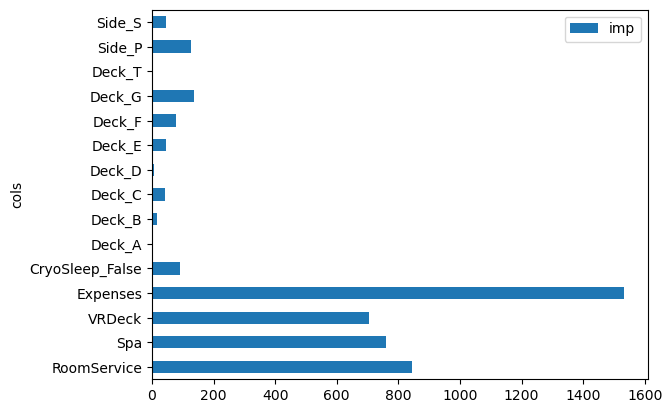

In [30]:
pd.DataFrame(dict(cols=X.columns, imp=lgbm_model.feature_importances_)).plot('cols', 'imp', 'barh');

## **##### 6. Submission**

In [31]:
pred_lgbm_best = (lgbm_model.fit(X,y)).predict(test)
sample['Transported'] = pred_lgbm_best

#This converts the numbers to True/False values
sample['Transported']=sample['Transported']>0.5
sample.to_csv('submit_lgbm_best_data.csv', index=False)